$$
\newcommand{\x}{\mathbf{x}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\price}{{p}}
\newcommand{\ret}{{r}}
\newcommand{\tp}{{(t)}}
\newcommand{\aapl}{{\text{AAPL}}}
\newcommand{\ba}{{\text{BA}}}
\newcommand{\spy}{{\text{SPY}}}
$$

# Assignment: Using Machine Learning for Hedging

Welcome to the first assignment.  

We will show how Machine Learning can be used in Finance to build multi-asset portfolios that have better risk/return characteristics than a portfolio consisting of a single asset.

# Objectives
We will be using Linear Regression to establish the relationship between the returns of individual equities and "the market".

The purpose of the assignment is two-fold
- to get you up to spped with Machine Learning in general, and `sklearn` in particular
- to get you up to speed with the other programming tools (e.g., Pandas) that will help you in data preparation, etc.

# How to report your answers
I will mix explanation of the topic with tasks that you must complete. Look for 
the string "**Queston**" to find a task that you must perform.
Most of the tasks will require you to assign values to variables and execute a `print` statement.

**Motivation**

If you *do not change* the print statement then the GA (or a machine) can automatically find your answer to each part by searching for the string.


# The data

The data are the daily prices of a number of individual equities and equity indices.
The prices are arranged in a series in ascending date order (a timeseries).
- There is a separate `.csv` file for each equity or index in the directory `data/assignment_1`

## Reading the data

You should get the price data into some sort of data structure.  Pandas DataFrame is super useful
so I recommend that's what you use (not required though).

**Hints**: 
- look up the Pandas `read_csv` method
- it will be very convenient to use dates as the index of your DataFrame

## Preliminary data preparation

In the rest of the assignment we will *not* be working with prices but with *returns* (percent change in prices).
For example, for ticker $\aapl$ (Apple)

$$
\begin{array}[lll]\\
\ret_\aapl^\tp = \frac{\price _\aapl^\tp}{\price _\aapl^{(t-1)}} -1 \\
\text{where} \\
\price_\aapl^\tp \text{ denotes the price of ticker } \aapl \text{ on date } t \\
\ret_\aapl^\tp \text{ denotes the return of ticker } \aapl \text{ on date } t
\end{array}
$$

- You will want to convert the price data into return data
- We only want the returns for the year 2018; discard any other return

**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements

In [1]:
# Common imports
import numpy as np
import os
import pandas as pd

#To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Read the Data
PROJECT_ROOT_DIR = "."
ASSIGNMENT_ID = "assignment_1"
PRICE_PATH = os.path.join(PROJECT_ROOT_DIR, "data", ASSIGNMENT_ID)

def load_price_data(file_name, column_name):
    csv_path = os.path.join(PRICE_PATH, file_name)
    return pd.read_csv(csv_path, names = ['Dt', column_name], parse_dates = ['Dt'], index_col=['Dt'], skiprows = 1)
AAPL = load_price_data("AAPL.csv","AAPL_p")
SPY = load_price_data("SPY.csv","SPY_p")
XLB = load_price_data("XLK.csv","XLK_p")
BA = load_price_data("BA.csv","BA_p")

#concatenate data
df = pd.concat([AAPL, SPY, XLB, BA],axis = 1)

#calculate returns
df['AAPL_R']=df['AAPL_p'] / df['AAPL_p'].shift(1) - 1
df['SPY_R']=df['SPY_p'] / df['SPY_p'].shift(1) - 1
df['XLK_R']=df['XLK_p'] / df['XLK_p'].shift(1) - 1
df['BA_R']=df['BA_p'] / df['BA_p'].shift(1) - 1
df['AAPL_pre_p']=df['AAPL_p'].shift(1)
df = df.loc['2018-01-01':]


In [2]:
num_returns =  len(df['AAPL_R']) # Number of returns in year 2018
first_return = df['AAPL_R'][0] # The return on the earliest date in 2018
last_return  = df['AAPL_R'][-1] # The return on the latest date in 2018
avg_return  =  df['AAPL_R'].mean() # The average return over the  year 2018

print("There are {num:d} returns. First={first:3.2f}, Last={last:3.2f}, Avg={avg:3.2f}".format(num=num_returns, first=first_return, last=last_return, avg=avg_return))

There are 251 returns. First=0.02, Last=0.01, Avg=-0.00


# Split into Train and Test datasets

In general, you will split the data into two sets by choosing the members of each set at random.

To facilitate grading for this assignment, we will *use a specific test set*
- the training set are the returns for the months of January through September (inclusive), i.e., 9 months
- the test set are the returns for the months of October through December (inclusive), i.e., 3 months

Thus, you will be using the early part of the data for training, and the latter part of the data for testing.

**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements

In [3]:
#split train set and test set
import datetime
dt1=datetime.date(year=2018,month=1,day=1)
dt2=datetime.date(year=2018,month=9,day=30)

dt3=datetime.date(year=2018,month=10,day=1)
dt4=datetime.date(year=2018,month=12,day=31)

df_train_set = df.loc[dt1:dt2].copy()
df_test_set = df.loc[dt3:dt4].copy()

In [4]:
train_num_returns = len(df_train_set['AAPL_R'])  # Number of returns in training set
train_first_return = df_train_set['AAPL_R'][0] # The return on the earliest date in training set
train_last_return  = df_train_set['AAPL_R'][-1] # The return on the latest date in training set
train_avg_return  =  df_train_set['AAPL_R'].mean() # The average return over the  year training set

print("Training set: There are {num:d} returns. First={first:3.2f}, Last={last:3.2f}, Avg={avg:3.2f}".format(num=train_num_returns, 
                                                                                                             first=train_first_return, 
                                                                                                             last=train_last_return, 
                                                                                                             avg=train_avg_return))

test_num_returns = len(df_test_set['AAPL_R'])  # Number of returns in test set
test_first_return = df_test_set['AAPL_R'][0] # The return on the earliest date in test set
test_last_return  = df_test_set['AAPL_R'][-1] # The return on the latest date in test set
test_avg_return  = df_test_set['AAPL_R'].mean()  # The average return over the  year test set

print("Test set: There are {num:d} returns. First={first:3.2f}, Last={last:3.2f}, Avg={avg:3.2f}".format(num=test_num_returns, 
                                                                                                         first=test_first_return, 
                                                                                                         last=test_last_return, 
                                                                                                         avg=test_avg_return))

Training set: There are 188 returns. First=0.02, Last=0.00, Avg=0.00
Test set: There are 63 returns. First=0.01, Last=0.01, Avg=-0.01


# $\aapl$ regression

Use Linear Regression to predict the return of a ticker from the return of the $\spy$ index.
For example, for ticker $\aapl$

$$
\ret_\aapl^\tp =  \beta_{\aapl, \spy} * \ret_\spy^\tp + \epsilon_{\aapl}^\tp
$$

That is
- each example is a pair consisting of one day's return 
    - of the ticker (e.g., $\aapl$).  This is the target (e.g, $\y$ in our lectures)
    - of the index $\spy$. This is a feature vector of length 1 (e.g., $\x$ in our lectures)

You will use Linear Regression to solve for parameter $\beta_{\aapl, \spy}$ 

- In the lectures we used the symbol $\Theta$ to denote the parameter vector; here we use $\mathbf{\beta}$
- In Finance the symbol $\beta$ is often used to denote the relationship between returns. 
- You may should add an "intercept" so that the feature vector is length 2 rather than length 1
    - $\x^\tp = \begin{pmatrix}
        1 \\
        \ret_\spy^\tp
        \end{pmatrix}$




- Report the $\mathbf{\beta}$ parameter vector you obtain for $\aapl$
    - you will subsequently do this for another ticker in a different part of the assignment
        - so think ahead: you may want to parameterize your code
        - change the assignment to `ticker` when you report the next part

        
**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements


In [5]:
# do linear regression on train set
def process(y):
    y_train=df_train_set[y]
    X_train=df_train_set['SPY_R']
    X_train=np.array(X_train).reshape(-1,1)
    return y_train, X_train
y1_train, X1_train = process('AAPL_R')
from sklearn.linear_model import LinearRegression
lin_reg1 = LinearRegression()
lin_reg1.fit(X1_train, y1_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [6]:
beta_0 = lin_reg1.intercept_    # The regression parameter for the constant
beta_SPY = lin_reg1.coef_[0]  # The regression parameter for the return of SPY
ticker = "AAPL"

print("{t:s}: beta_0={b0:3.2f}, beta_SPY={b1:3.2f}".format(t=ticker, b0=beta_0, b1=beta_SPY))


AAPL: beta_0=0.00, beta_SPY=1.07


- Report the average of the cross validation scores, using 5 fold cross validation

**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements


In [7]:
from sklearn.model_selection import cross_val_score
scores_1 = cross_val_score(lin_reg1, X1_train, y1_train, cv=5)

In [8]:
cross_val_avg = scores_1.mean()

print("{t:s}: Avg cross val score = {sc:3.2f}".format(t=ticker, sc=cross_val_avg) )

AAPL: Avg cross val score = 0.33


## $\aapl$ hedged returns

- Compute the series
$$
{\ret'}_{\aapl}^\tp = \ret_\aapl^\tp - \beta_{\aapl, \spy} * \ret_\spy^\tp
$$
for all dates $t$ in the test set.  
- Sort the dates in ascending order and plot the timeseries ${\ret}'_{\aapl}$

${\ret}'_{\aapl}$ is called the "hedged return" of $\aapl$
- It is the daily return you would realize if you created a portfolio that was
    - long 1 dollar of $\aapl$
    - short $\beta_{\aapl, \spy}$ dollars of the index $\spy$
- It represents the outperformance of $\aapl$ relative to the index $\spy$
    - $\spy$ is the proxy for "the market" (it tracks the S&P 500 index)
    - The hedged return is the *value added* by going long $\aapl$ rather than just going "long the market"
    - Sometimes referred to as the "alpha" ($\alpha_\aapl$)
- So **if** you are able to correctly forecast that $\aapl$ will have positive outperformance (i.e, have $\alpha_\aapl > 0$ most days)
    - then you can earn a positive return regardless of whether the market ($\spy$) goes up or down !
    - this is much lower risk than just holding $\aapl$ long
    - people will pay you very well if you can really forecast correctly !

**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements

In [9]:
AAPL_hedged_returns = df_test_set['AAPL_R'] - beta_SPY * df_test_set['SPY_R']

In [10]:
hedged_num_returns = len(AAPL_hedged_returns)  # Number of returns in hedged series
hedged_first_return = AAPL_hedged_returns[0] # The return on the earliest date in hedged series
hedged_last_return  = AAPL_hedged_returns[-1] # The return on the latest date in hedged series
hedged_avg_return  = AAPL_hedged_returns.mean()  # The average return over the hedged series

ticker="AAPL"
print("{t:s} hedged returns: There are {num:d} returns. First={first:3.2f}, Last={last:3.2f}, Avg={avg:3.2f}".format(t=ticker,
                                                                                                                    num=hedged_num_returns,
                                                                                                                    first=hedged_first_return, 
                                                                                                                    last=hedged_last_return, 
                                                                                                                    avg=hedged_avg_return))

AAPL hedged returns: There are 63 returns. First=0.00, Last=0.00, Avg=-0.00


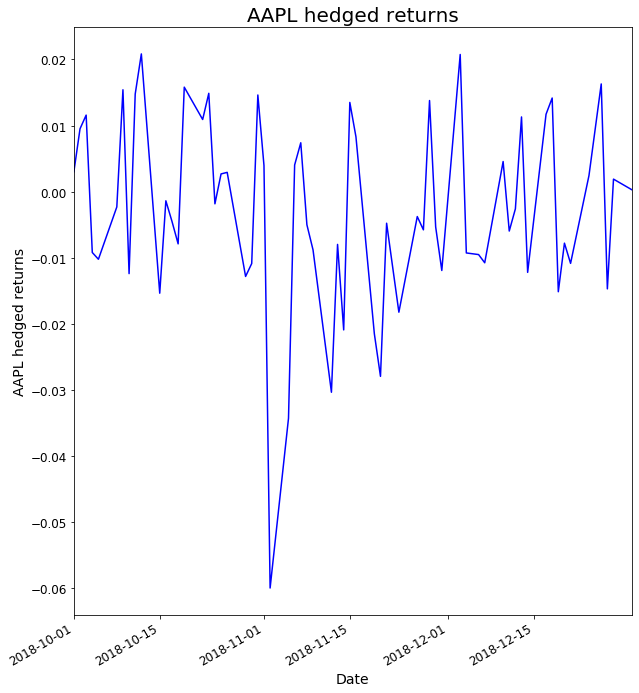

In [11]:
# plot the time series AAPL_hedged_return
def pic(x,y):
    x=x.sort_index() # sort the dates in ascending order
    plt.figure(figsize=(10,12))
    ax=x.plot(color='blue')
    ax.set_xlabel('Date')
    ax.set_ylabel(y)
    ax.set_title(y, fontsize=20)
    p = plt.show()
    return p
pic(AAPL_hedged_returns,'AAPL hedged returns')

# $\ba$ regression

Repeat the regression you carried out for $\aapl$ but this time instead for the ticker $\ba$ (Boeing)

**Motivation**

The idea is to encourage you to build re-usable pieces of code.

So if you created some functions in solving Part 1, you may reuse these functions to easily solve part 2,
particulary if you treated the ticker (e.g., $\aapl$ or $\ba$) as a parameter to your functions.

If you simply copy and paste the code from Part 1 you will only get partial credit.


**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements

In [12]:
y2_train, X2_train = process('BA_R')
lin_reg2 = LinearRegression()
lin_reg2.fit(X2_train, y2_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [13]:
beta_0 = lin_reg2.intercept_    # The regression parameter for the constant
beta_SPY = lin_reg2.coef_[0]  # The regression parameter for the return of SPY
ticker = "BA"

print("{t:s}: beta_0={b0:3.6f}, beta_SPY={b1:3.2f}".format(t=ticker, b0=beta_0, b1=beta_SPY))


BA: beta_0=0.000723, beta_SPY=1.36


**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements

In [14]:
scores_2 = cross_val_score(lin_reg2, X2_train, y2_train, cv=5)

In [15]:
cross_val_avg = scores_2.mean()

print("{t:s}: Avg cross val score = {sc:3.2f}".format(t=ticker, sc=cross_val_avg) )

BA: Avg cross val score = 0.39


**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements

In [16]:
BA_hedged_returns = df_test_set['BA_R'] - beta_SPY * df_test_set['SPY_R']

In [17]:
hedged_num_returns = len(BA_hedged_returns)  # Number of returns in hedged series
hedged_first_return = BA_hedged_returns[0] # The return on the earliest date in hedged series
hedged_last_return  = BA_hedged_returns[-1] # The return on the latest date in hedged series
hedged_avg_return  = BA_hedged_returns.mean()  # The average return over the hedged series

ticker="BA"
print("{t:s} hedged returns: There are {num:d} returns. First={first:3.2f}, Last={last:3.2f}, Avg={avg:3.2f}".format(t=ticker,
                                                                                                                    num=hedged_num_returns,
                                                                                                                    first=hedged_first_return, 
                                                                                                                    last=hedged_last_return, 
                                                                                                                    avg=hedged_avg_return))


BA hedged returns: There are 63 returns. First=0.02, Last=0.01, Avg=0.00


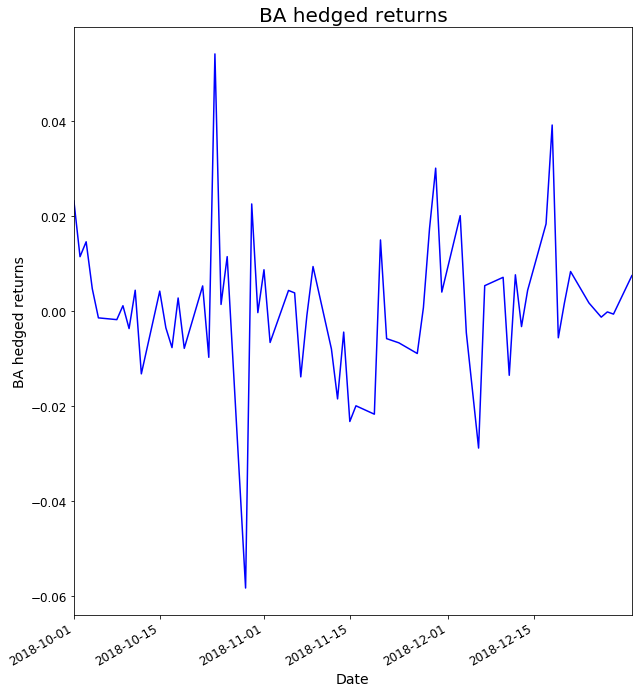

In [18]:
pic(BA_hedged_returns,'BA hedged returns')

# Returns to prices

- You have already computed the predicted returns of $\aapl$ for each date in the test set.
- Create the predicted *price* timeseries for $\aapl$ for the date range in the test set
- Plot (on the same graph) the actual price timeseries of $\aapl$ and the predicted price timeseries.

There is a particular reason that we choose to perform the Linear Regression on returns rather than prices.

It is beyond the scope of this lecture to explain why, but we want to show that we can easily convert
back into prices.

**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements

In [19]:
n=np.array(df_test_set['SPY_R']).reshape(-1,1)
df_test_set['AAPL_r']=lin_reg1.predict(n)
df_test_set['AAPL_pprime']=df_test_set['AAPL_pre_p']*(1+df_test_set['AAPL_r'])

In [20]:
num_prices = len(df_test_set['AAPL_pprime'])  # Number of prices in price series
first_price = df_test_set['AAPL_pprime'][0] # The price on the earliest date in price series
last_price  = df_test_set['AAPL_pprime'][-1] # The price on the latest date in price series
avg_price  = df_test_set['AAPL_pprime'].mean()  # The average price over the price series

ticker="AAPL"
print("{t:s} predicted prices: There are {num:d} prices. First={first:3.2f}, Last={last:3.2f}, Avg={avg:3.2f}".format(t=ticker,
                                                                                                                    num=num_prices,
                                                                                                                    first=first_price, 
                                                                                                                    last=last_price, 
                                                                                                                    avg=avg_price))
 

AAPL predicted prices: There are 63 prices. First=226.83, Last=157.87, Avg=194.70


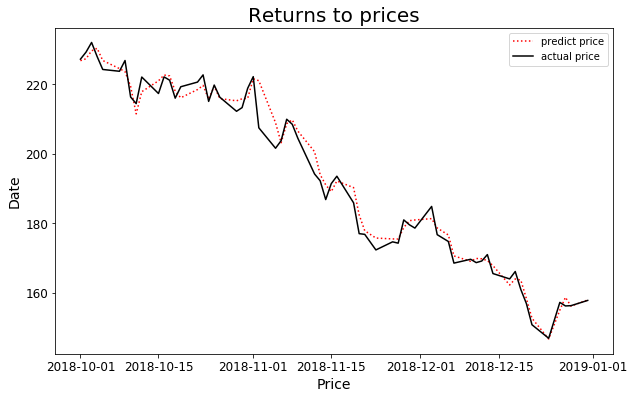

In [21]:
plt.figure(figsize=(10,6))
plt.title('Returns to prices',fontsize=20)
plt.xlabel(u'Price',fontsize=14)
plt.ylabel(u'Date',fontsize=14)
plt.plot(df_test_set.index,df_test_set['AAPL_pprime'],linestyle=':',label='predict price',color='r')
plt.plot(df_test_set.index,df_test_set['AAPL_p'],linestyle='-',label='actual price', color='k')

plt.legend(loc=1)
plt.show()

# Extra credit

The data directory has the prices of many other indices.
- Any ticker in the directory beginning with the letter "X" is an index

Choose *one* index (we'll call it $I$) other than $\spy$ to use as a second feature and compute the Linear Regression

$$
\ret_\aapl^\tp = \beta^T \x + \epsilon_{\aapl}^\tp
$$

where $\x$ is the feature vector
  - $\x^\tp = \begin{pmatrix}
        1 \\
        \ret_\spy^\tp \\
        \ret_I^\tp \\
        \end{pmatrix}$

That is, predict the returns of $\aapl$ in terms of a constant, the returns of $\spy$ and the returns of another index $I$.

**Question**
There is no specified format.  Treat this like an interview question and show off your analytical
and explanatory skills. Be sure to explain how you came about choosing the second index.

In [22]:
X3_train=df_train_set[['SPY_R','XLK_R']]
y3_train=df_train_set['AAPL_R']
lin_reg3 = LinearRegression()
lin_reg3.fit(X3_train, y3_train)
scores = cross_val_score(lin_reg3, X3_train, y3_train, cv=5)
cross_val_avg = np.mean(scores)

beta_0 = lin_reg3.intercept_    # The regression parameter for the constant
beta_SPY = lin_reg3.coef_[0]  # The regression parameter for the return of SPY
beta_XLK = lin_reg3.coef_[1]  # The regression parameter for the return of XLK
ticker = "AAPL"

print("{t:s}: beta_0={b0:3.6f}, beta_SPY={b1:3.2f}, beta_XLK = {b2:3.2f}".format(t=ticker, b0=beta_0, b1=beta_SPY,b2=beta_XLK))
print("{t:s}: Avg cross val score = {sc:3.2f}".format(t=ticker, sc=cross_val_avg) )

AAPL: beta_0=0.000598, beta_SPY=-0.79, beta_XLK = 1.52
AAPL: Avg cross val score = 0.55
